<center><img src="Fig/Ensimag.png" width="30%" height="30%"></center>
<center><h3>ENSIMAG  -- 2A</h3></center>
<hr>
<center><h1>Optimisation Numérique</h1></center>
<center><h2>TP : Linear and Quadratic programs (1.5h)</h2></center>

# Structure of an optimization program

An optimization program can be practically divided into three parts:
* the *run* environment, in which you test, run your program, and display results.
* the *problem* part, which contains the function oracles, problem constraints, etc.
* the *algorithmic* part, where the algorithms are coded.

The main interest of such division is that these parts are interchangeable, meaning that, for instance, the algorithms of the third part can be used of a variety of problems. That is why such a decomposition is widely used.

In the present lab, you will use this division:
* `LP_and_QP_problems.ipynb` will be the *run* environment
* `toy_problem.ipynb` will be the considered the *problem* for this lab
* the library `cvxopt` will be used for solving all optimization problems

---

The following script will allow you to import *notebooks* as if you imported *python files* and will have to be executed at each time you launch Jupyter notebooks.

In [1]:
import start
import import_ipynb
from importlib import reload

---

# Regression model


We consider the regression model

$$ y=X\theta+\xi,\;\;\xi\sim \mathcal{N}(0, \sigma I_m), $$

where $X\in \mathbb{R}^{m\times n}$ and $y\in \mathbb{R}^m$ are the observed values and $\theta\in \mathbb{R}^n$ is the unknown parameter we want to find. 

We want to find a value $\widehat{\theta}$ such that 
- the quadratic error $e(\widehat{\theta}) = 1/2 \|X\widehat{\theta} - y \|_2^2$ is (near)-minimal, that is $ \| \nabla e(\widehat{\theta}) \| = \| X^\mathrm{T} (X\widehat{\theta} - y) \| $ is small.

---

# the Dantzig Selector


The **Dantzig Selector** for $\theta$, introduced in *Emmanuel Candes and Terrence Tao "The Dantzig selector: Statistical estimation when $p$ is much larger than $n$". The Annals of Statistics, 2007* can be used to estimate $\theta$ in the case of an overparametrized problem, i.e. when the dimension $n$ of $\theta$ is well greater than the dimension of the observation $y$. 




In that case, the estimator $\widehat{\theta}_{DS}$ is the solution of the optimization problem 
$$
\widehat{\theta}_{DS} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{\|\theta\|_1,\;\mbox{with}\;\|X^T(X\theta-y)\|_\infty\leq \kappa\sigma\right\},
$$
where $\kappa>0$ is an *hyper-parameter*. 


The best theoretical value for $\kappa$ is $\nu q_{\mathcal{N}} \left(1-\frac{\alpha}{2n}\right)$, where  $\alpha\in(0,1)$ is the chosen risk level (e.g. $\alpha=.05$), $q_\mathcal{N}(p)$ is the $p$-quantile of the standard normal distribution, and $\nu=\max_j\|[X]_j\|_2$ is the maximal column norm of matrix $X$.


**Objective:** Implement a function that return the Dantzig estimator $\widehat{\theta}_{DS}$ from input $(y,X,\sigma)$ using linear programming solver `cvxopt`.

> Reformulate the $\arg\min$ problem as a linear program.


> Write a function `DantzigSelector` that takes `y,X,sigma` as an input and outputs $\widehat{\theta}_{DS}$ by using the linear program solver of the library `cvxopt` <a href="http://cvxopt.org/userguide/coneprog.html#linear-programming">lp</a> which, given $c, G, h$ solves the problem
$$ \min_x c^\mathrm{T}x ~~~~~~ \text{ subject to } Gx \leq h $$
where the inequality is elementwise.

*Hint: Useful functions are* `np.concatenate` `np.zeros` `np.eye` `np.hstack` `np.vstack`

In [2]:
from cvxopt import matrix, solvers

from scipy.stats import norm
import numpy as np

def DantzigSelector(y, X, sigma):
    # Extracting the sizes
    m, n = X.shape

    # Computing kappa
    alpha = 0.05
    nu = np.max(np.linalg.norm(X, axis=0))
    kappa = nu * norm.ppf(1 - alpha / (2.0 * n))

    #####################################################
    # COMPUTE AND SOLVE LP PROBLEM
    #####################################################
    # Prepare c, G, h
    c = np.concatenate([np.ones(n), np.ones(n)])
    assert c.shape == (2 * n,)

    # Construction de G
    G1 = np.hstack([-X.T @ X, X.T @ X])
    G2 = np.hstack([X.T @ X, -X.T @ X])
    G3 = -np.eye(2*n) # Positivity constraint
    G = np.vstack([G1, G2, G3])
    assert G.shape == (4 * n, 2 * n)

    # Construction de h
    h = np.concatenate([
        kappa * sigma - X.T @ y,
        kappa * sigma + X.T @ y,
        np.zeros(2*n) # Positivity constraint
    ])
    assert h.shape == (4 * n,)

    # Convert to CVXOPT matrices
    c_cvx = matrix(c)
    G_cvx = matrix(G)
    h_cvx = matrix(h)

    # Solve the LP
    sol = solvers.conelp(c=c_cvx, G=G_cvx, h=h_cvx)
    if sol['status'] != 'optimal':
        print(sol['status'])
        raise ValueError("The solver did not find an optimal solution.")

    x_cvx = sol['x']
    x = np.array(x_cvx).flatten()
    assert x.shape == (2 * n,)

    # Extract theta
    theta = x[:n] - x[n:]
    assert theta.shape == (n,)

    return theta

> Test your code on the toy problem given in `toy_problem.ipynb`. For this randomly generated problem, there is a true $\theta$ upon which the problem is built.

In [3]:
import toy_problem as tPb
reload(tPb)

theta_ds = DantzigSelector(tPb.y,tPb.X,tPb.sigma)


     pcost       dcost       gap    pres   dres   k/t
 0: -2.9664e-15 -2.1191e+02  2e+03  3e+00  1e+00  1e+00
 1: -8.9325e+00 -2.5322e+01  8e+01  2e-01  8e-02  1e+00
 2: -1.8334e+00 -9.0913e+00  3e+01  1e-01  4e-02  4e-01
 3: -2.7640e-01 -5.5298e+00  2e+01  8e-02  3e-02  2e-01
 4:  2.1846e+00  2.1815e-01  8e+00  3e-02  1e-02  7e-02
 5:  3.5230e+00  3.2201e+00  1e+00  4e-03  1e-03  4e-03
 6:  3.7938e+00  3.7767e+00  7e-02  2e-04  8e-05  2e-04
 7:  3.8096e+00  3.8094e+00  7e-04  3e-06  9e-07  2e-06
 8:  3.8098e+00  3.8098e+00  7e-06  3e-08  9e-09  2e-08
 9:  3.8098e+00  3.8098e+00  7e-08  3e-10  9e-11  2e-10
Optimal solution found.


> Investigate the differences between the Dantzig selector and the Ground truth

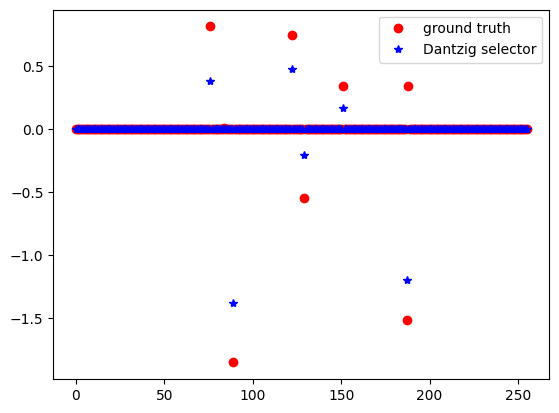

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(tPb.theta,'ro',label='ground truth')
plt.plot(theta_ds,'b*',label='Dantzig selector')
plt.legend()
plt.show()

---

# the Lasso

Under the same regression model, the Least Absolute Shrinkage and Selection Operator or **lasso** for $\theta$, introduced in *Robert Tibshirani "Regression shrinkage and selection via the lasso", Journal of the Royal Statistical Society, 1996* can also be used to estimate $\theta$. 

The estimator $\widehat{\theta}_{L}$ is the solution of the optimization problem 
$$
\widehat{\theta}_{L} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{ \|X\theta - y\|_2^2 + \kappa \sigma \|\theta\|_1 \right\},
$$
where $\kappa>0$ is an *hyper-parameter*. 


The best theoretical value for $\kappa$ is the same as for the Dantzig selector: $\nu q_{\mathcal{N}} \left(1-\frac{\alpha}{2n}\right)$, where  $\alpha\in(0,1)$ is the chosen risk level (e.g. $\alpha=.05$), $q_\mathcal{N}(p)$ is the $p$-quantile of the standard normal distribution, and $\nu=\max_j\|[X]_j\|_2$ is the maximal column norm of matrix $X$.


**Objective:** Implement a function that return the lasso estimator $\widehat{\theta}_{L}$ from input $(y,X,\sigma)$ using quadratic programming solver `cvxopt`.


> Reformulate the $\arg\min$ problem as a quadratic program.


> Write a function `Lasso` that takes `y,X,sigma` as an input and outputs $\widehat{\theta}_{L}$ by using the quadratic program solver of the library `cvxopt` <a href="http://cvxopt.org/userguide/coneprog.html#quadratic-programming">qp</a> which, given $P,q, G, h$ solves the problem
$$ \min_x 1/2 x^\mathrm{T} P x + q^\mathrm{T}x ~~~~~~ \text{ subject to } Gx \leq h $$
where the inequality is elementwise.

*Hint: Useful functions are* `np.concatenate` `np.zeros` `np.eye` `np.hstack` `np.vstack`

In [5]:
from cvxopt import matrix, solvers

from scipy.stats import norm
import numpy as np

def Lasso(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    # Computing kappa
    alpha = 0.05
    nu = max(np.linalg.norm(X, axis=0))
    kappa = nu*norm.ppf(1-alpha/(2.0*n))
    
    #####################################################
    # COMPUTE AND SOLVE QP PROBLEM
    #####################################################
    # Prepare P, q, G, h
    P = np.vstack([
        np.hstack([X.T @ X, -X.T @ X]),
        np.hstack([-X.T @ X, X.T @ X])
    ])
    assert P.shape == (2*n, 2*n)
    q = np.concatenate([
        -X.T @ y + kappa * sigma * np.ones(n),
        X.T @ y +  kappa * sigma * np.ones(n)
    ])
    assert q.shape == (2*n,)
    G = np.vstack([
        np.hstack([X.T @ X, -X.T @ X]),
        -np.eye(2*n)
    ])
    assert G.shape == (3*n, 2*n)
    h = np.concatenate([
        X.T @ y +  kappa * sigma * np.ones(n),
        np.zeros(2*n)
    ])
    assert h.shape == (3*n,)
    P_cvx = matrix(P)
    q_cvx = matrix(q)
    G_cvx = matrix(G)
    h_cvx = matrix(h)
    
    sol = solvers.qp(P_cvx, q_cvx, G_cvx, h_cvx)
    x_cvx = sol['x']
    x = np.squeeze(np.array(x_cvx))
    assert x.shape == (2*n,)
    
    theta = x[:n] - x[n:] # x[:n]
    assert theta.shape == (n,)
    
    return theta

> Test your code on the toy problem given in `toy_problem.ipynb`. For this randomly generated problem, there is a true $\theta$ upon which the problem is built.

In [6]:
import toy_problem as tPb
reload(tPb)


theta_l = Lasso(tPb.y,tPb.X,tPb.sigma)


     pcost       dcost       gap    pres   dres
 0: -9.1682e+01  2.5178e+02  2e+03  5e+00  7e+00
 1:  1.5768e+02 -1.5574e+02  4e+02  5e-01  7e-01
 2:  5.8309e+01 -4.3890e+01  1e+02  1e-01  2e-01
 3:  4.5894e+01 -2.8348e+01  8e+01  2e-02  3e-02
 4:  9.4364e+00 -9.5959e+00  2e+01  4e-03  6e-03
 5:  5.8700e-01 -4.8405e+00  5e+00  3e-04  5e-04
 6: -2.6853e+00 -3.0620e+00  4e-01  2e-05  2e-05
 7: -2.9300e+00 -2.9407e+00  1e-02  4e-07  6e-07
 8: -2.9366e+00 -2.9369e+00  3e-04  5e-09  7e-09
 9: -2.9368e+00 -2.9368e+00  2e-05  5e-11  7e-11
10: -2.9368e+00 -2.9368e+00  2e-06  2e-13  3e-13
Optimal solution found.


> Investigate the differences between the Lasso and the Ground truth

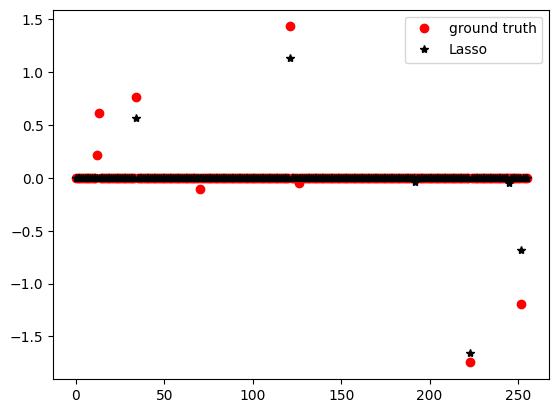

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(tPb.theta,'ro',label='ground truth')
plt.plot(theta_l,'k*',label='Lasso')
plt.legend()
plt.show()

# Comparing and Improving


> Compute the lasso and Dantzig selector solutions for the same problem and investigate their compared performance graphically and by computing the error on the null and non-null coordinates of theta.


> Play with the values of $n,m,\sigma, S$ to exhibit differences in behaviors.


In [8]:
import toy_problem as tPb
reload(tPb)


theta_l = Lasso(tPb.y,tPb.X,tPb.sigma)
theta_ds = DantzigSelector(tPb.y,tPb.X,tPb.sigma)

     pcost       dcost       gap    pres   dres
 0: -8.9679e+01  2.5840e+02  2e+03  5e+00  8e+00
 1:  1.3233e+02 -2.0500e+02  5e+02  9e-01  1e+00
 2:  3.5129e+01 -1.9438e+01  5e+01  2e-15  9e-15
 3:  1.7111e+01 -1.0041e+01  3e+01  7e-16  2e-15
 4:  1.6807e+00 -2.3520e+00  4e+00  6e-16  1e-15
 5: -3.0800e-01 -1.2711e+00  1e+00  5e-16  1e-15
 6: -9.0344e-01 -9.5324e-01  5e-02  5e-16  1e-15
 7: -9.3468e-01 -9.3583e-01  1e-03  4e-16  1e-15
 8: -9.3534e-01 -9.3540e-01  6e-05  4e-16  1e-15
 9: -9.3537e-01 -9.3538e-01  5e-06  5e-16  1e-15
10: -9.3537e-01 -9.3537e-01  5e-07  5e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1162e-15 -2.1191e+02  2e+03  3e+00  1e+00  1e+00
 1: -8.6142e+00 -2.5458e+01  8e+01  3e-01  8e-02  1e+00
 2: -2.7272e+00 -1.0427e+01  3e+01  1e-01  4e-02  4e-01
 3: -2.6110e-01 -3.9636e+00  2e+01  6e-02  2e-02  2e-01
 4:  8.4594e-01 -1.2607e+00  9e+00  3e-02  1e-02  6e-02
 5:  1.7618e+00  9.8373e-01  3e+00  1e-02  4e-03  5e-03

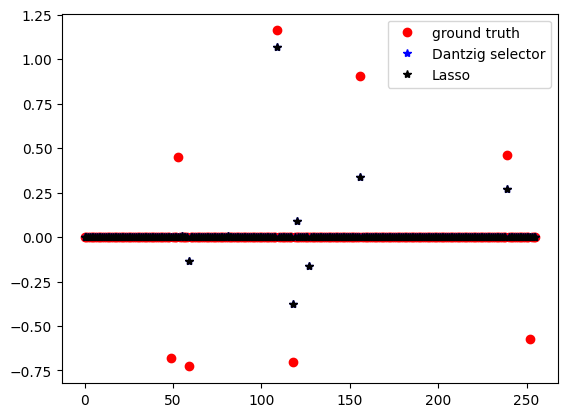

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(tPb.theta,'ro',label='ground truth')
plt.plot(theta_ds,'b*',label='Dantzig selector')
plt.plot(theta_l,'k*',label='Lasso')
plt.legend()
plt.show()



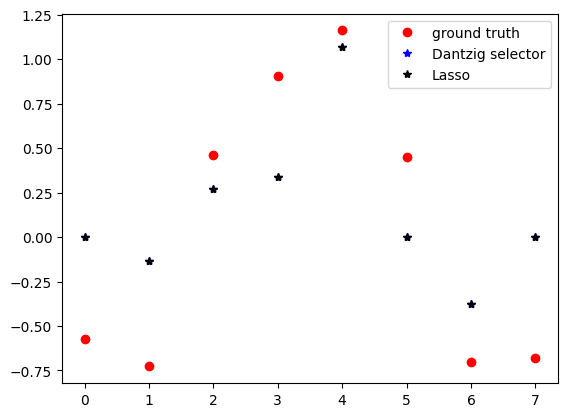

Error on the non-null coefficients
 Dantzig selec. 	 Lasso
3.4675321896364824 3.4668183658046146


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline



plt.figure()
plt.plot(tPb.theta[tPb.non_null],'ro',label='ground truth')
plt.plot(theta_ds[tPb.non_null],'b*',label='Dantzig selector')
plt.plot(theta_l[tPb.non_null],'k*',label='Lasso')
plt.legend()
plt.show()

err_theta_DS = np.linalg.norm(theta_ds[tPb.non_null] -tPb.theta[tPb.non_null]  , ord=1)
err_theta_L = np.linalg.norm(theta_l[tPb.non_null]-tPb.theta[tPb.non_null] , ord=1)

print("Error on the non-null coefficients\n Dantzig selec. \t Lasso")
print(err_theta_DS,err_theta_L)

In [11]:
err_supp_DS = 0
err_supp_L = 0
for i in range(tPb.n):
    if i not in  tPb.non_null:
        err_supp_DS += np.abs(theta_ds[i])
        err_supp_L += np.abs(theta_l[i])

print("Error on the null coefficients\n Dantzig selec. \t Lasso")
print(float(err_supp_DS),float(err_supp_L))
        

Error on the null coefficients
 Dantzig selec. 	 Lasso
0.26340894144372917 0.26371803079341954


In [12]:
print("Error on y \n Dantzig selec. \t Lasso")
print(float(np.linalg.norm(np.dot(tPb.X, theta_ds ) - tPb.y )),float(np.linalg.norm(np.dot(tPb.X, theta_l ) - tPb.y )))   

Error on y 
 Dantzig selec. 	 Lasso
1.5355674881768635 1.535291839137889


In [13]:
print("Quadratic error \n Dantzig selec. \t Lasso")
print(float(np.linalg.norm(np.dot(tPb.X.T , np.dot(tPb.X, theta_ds ) - tPb.y ))),float(np.linalg.norm(np.dot(tPb.X.T , np.dot(tPb.X, theta_l ) - tPb.y )))) 

Quadratic error 
 Dantzig selec. 	 Lasso
2.8901824027595198 2.889610551284639


# To go further


### Improved Estimators

A popular improvement of these estimators is to weigh the threshold $\kappa$ with the norm corresponding column of $X$.

The improved Dantzig and Lasso estimators $\widehat{\theta'}_{DS}$ and $\widehat{\theta'}_{L}$  are thus solutions of  
$$
\widehat{\theta}_{DS} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{\|\theta\|_1,\;{with}\;| [ X^T(X\theta-y)]_i  | \leq \kappa_i \sigma ~~ \forall i\right\},
$$
and
$$
\widehat{\theta}_{L} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{ \|X\theta - y\|_2^2 + \sum_{i=1}^n \kappa_i \sigma |\theta_i | \right\},
$$
where $\kappa_i = \| X_i \|_2 \kappa = \| X_i \|_2 q_{\mathcal{N}} \left(1-\frac{\alpha}{2n}\right) $ where $\| X_i \|_2$ is the $2$-norm of the $i$-th column of $X$.



> Investigate the pertinence of this improvement. (Get rid of the normalization in the problem). 

In [14]:
from cvxopt import matrix, solvers

from scipy.stats import norm
import numpy as np

def DantzigSelectorImproved(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    # Computing kappa
    alpha = 0.05
    #### WARNING: Error in the question !
    nu = 1 #max(np.linalg.norm(X, axis=0))
    kappa = nu*norm.ppf(1-alpha/(2.0*n))
    
    # Kappa vector
    kappa_vec = np.linalg.norm(X, ord=2, axis=0) * kappa
    assert kappa_vec.shape == (n,)
    
    #####################################################
    # COMPUTE AND SOLVE LP PROBLEM
    #####################################################
    # Prepare c, G, h
    c = np.concatenate([np.ones(n), np.ones(n)])
    G = np.vstack([
        np.hstack([-X.T @ X, X.T @ X]),
        np.hstack([X.T @ X, -X.T @ X]),
        -np.eye(2*n)
    ])
    h = np.concatenate([
        sigma * kappa_vec - X.T @ y,
        sigma * kappa_vec + X.T @ y,
        np.zeros(2*n)
    ])
    c_cvx = matrix(c)
    G_cvx = matrix(G)
    h_cvx = matrix(h)
    
    sol = solvers.conelp(c_cvx, G_cvx, h_cvx)
    x_cvx = sol['x']
    x = np.squeeze(np.array(x_cvx))
    assert x.shape == (2*n,)
    
    theta = x[:n] - x[n:] # x[:n]
    assert theta.shape == (n,)
    
    return  theta

In [15]:
from cvxopt import matrix, solvers

from scipy.stats import norm
import numpy as np

def LassoImproved(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    # Computing kappa
    alpha = 0.05
    nu = 1 # max(np.linalg.norm(X, axis=0))
    kappa = nu*norm.ppf(1-alpha/(2.0*n))
    
    # Kappa vector
    kappa_vec = np.linalg.norm(X, ord=2, axis=0) * kappa
    assert kappa_vec.shape == (n,)
    
    #####################################################
    # COMPUTE AND SOLVE QP PROBLEM
    #####################################################
    # Prepare P, q, G, h
    P = np.vstack([
        np.hstack([X.T @ X, -X.T @ X]),
        np.hstack([-X.T @ X, X.T @ X])
    ])
    q = np.concatenate([
        -X.T @ y + kappa_vec * sigma * np.ones(n),
        X.T @ y +  kappa_vec * sigma * np.ones(n)
    ])
    G = np.vstack([
        np.hstack([X.T @ X, -X.T @ X]),
        -np.eye(2*n)
    ])
    h = np.concatenate([
        X.T @ y +  kappa_vec * sigma * np.ones(n),
        np.zeros(2*n)
    ])
    P_cvx = matrix(P)
    q_cvx = matrix(q)
    G_cvx = matrix(G)
    h_cvx = matrix(h)
    
    sol = solvers.qp(P_cvx, q_cvx, G_cvx, h_cvx)
    x_cvx = sol['x']
    x = np.squeeze(np.array(x_cvx))
    assert x.shape == (2*n,)
    
    theta = x[:n] - x[n:] # x[:n]
    assert theta.shape == (n,)
    
    return theta

In [16]:
import toy_problem as tPb
reload(tPb)

theta_l = Lasso(tPb.y,tPb.X,tPb.sigma)
theta_ds = DantzigSelector(tPb.y,tPb.X,tPb.sigma)
theta_li = LassoImproved(tPb.y,tPb.X,tPb.sigma)
theta_dsi = DantzigSelectorImproved(tPb.y,tPb.X,tPb.sigma)

     pcost       dcost       gap    pres   dres
 0: -8.8362e+01  2.5356e+02  2e+03  6e+00  1e+01
 1:  1.3944e+02 -1.8399e+02  4e+02  8e-01  1e+00
 2:  3.3317e+01 -1.8940e+01  5e+01  4e-02  7e-02
 3:  2.6539e+01 -1.4524e+01  4e+01  1e-02  2e-02
 4:  3.8633e+00 -2.3877e+00  6e+00  1e-03  2e-03
 5:  7.6534e-01 -6.7799e-01  1e+00  2e-04  4e-04
 6: -7.1669e-05 -2.2132e-01  2e-01  1e-05  2e-05
 7: -1.3553e-01 -1.4451e-01  9e-03  5e-07  8e-07
 8: -1.4108e-01 -1.4125e-01  2e-04  7e-09  1e-08
 9: -1.4119e-01 -1.4119e-01  6e-06  8e-11  1e-10
10: -1.4119e-01 -1.4119e-01  5e-07  7e-13  1e-12
11: -1.4119e-01 -1.4119e-01  7e-08  7e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  5.7428e-15 -2.1191e+02  2e+03  4e+00  1e+00  1e+00
 1: -9.1308e+00 -2.5573e+01  7e+01  3e-01  8e-02  1e+00
 2: -4.1979e+00 -1.2301e+01  3e+01  1e-01  4e-02  5e-01
 3: -1.8548e+00 -5.5278e+00  1e+01  6e-02  2e-02  1e-01
 4: -6.6375e-01 -2.8364e+00  9e+00  4e-02  1e-02  5e-02
 5:  2

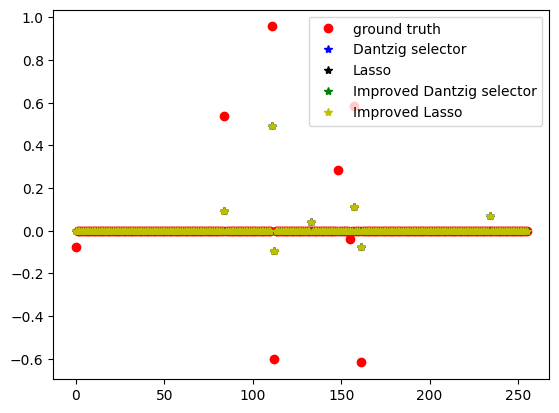

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(tPb.theta,'ro',label='ground truth')
plt.plot(theta_ds,'b*',label='Dantzig selector')
plt.plot(theta_l,'k*',label='Lasso')
plt.plot(theta_dsi,'g*',label='Improved Dantzig selector')
plt.plot(theta_li,'y*',label='Improved Lasso')
plt.legend()
plt.show()

In [18]:
err_theta_DS = np.linalg.norm(theta_ds[tPb.non_null] -tPb.theta[tPb.non_null]  , ord=1)
err_theta_L = np.linalg.norm(theta_l[tPb.non_null]-tPb.theta[tPb.non_null] , ord=1)
err_theta_DSI = np.linalg.norm(theta_dsi[tPb.non_null] -tPb.theta[tPb.non_null]  , ord=1)
err_theta_LI = np.linalg.norm(theta_li[tPb.non_null]-tPb.theta[tPb.non_null] , ord=1)

print("Error on the non-null coefficients")
print(err_theta_DS,err_theta_L, err_theta_DSI, err_theta_LI)

Error on the non-null coefficients
2.8363076592570255 2.8359265211868054 2.8363076592570247 2.8359265211868045


### Crossed Validation of the thresholds

The values of $\kappa$ is heavily linked to the noise standard deviation $\sigma$ and theoretical considerations about $X$ and $\theta$. A practical way to choose $\kappa$ without the knowledge of $\sigma$ is to use *cross-validation*.

- Split y and X in two parts column-wise, one part for *training* and one for *testing*.
- For several values of $\kappa$, solve the estimation problem *on the training part* using $\kappa$ to get a estimate $\widehat{\theta}_\kappa$.
- For each $\widehat{\theta}_\kappa$, compute the error *on the testing part* $e(\kappa) = \| y_{test}-X_{test}\widehat{\theta}_\kappa \|$.  
- Choose the value that minimize this error $\widehat{\kappa} = \arg \min_{\kappa} e(\kappa)$.


> Implement a cross validation procedure to choose $\kappa$. Compare the value and the outputted estimate with the theoretic value.